# This notebook aims to compare inference time and performance of student models trained on bigger models

# Imports

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import time
import copy
import codecarbon
from typing import List, Tuple, Optional, Dict, Union

# Load CIFAR-10

In [2]:
# load cifar10 dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10


def load_cifar10(
    batch_size: int = 32, num_workers: int = 4
) -> Tuple[DataLoader, DataLoader]:
    """
    Load CIFAR-10 dataset and return the data loaders for training and testing.

    Args:
        batch_size (int): The batch size for the data loaders. Default is 32.
        num_workers (int): The number of worker threads for data loading. Default is 4.

    Returns:
        Tuple[DataLoader, DataLoader]: A tuple containing the training data loader and the testing data loader.
    """
    # transform the data
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    # load the training data
    trainset = CIFAR10(root="../data", train=True, download=True, transform=transform)
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    # load the test data
    testset = CIFAR10(root="../data", train=False, download=True, transform=transform)
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )
    return trainloader, testloader

Files already downloaded and verified
Files already downloaded and verified


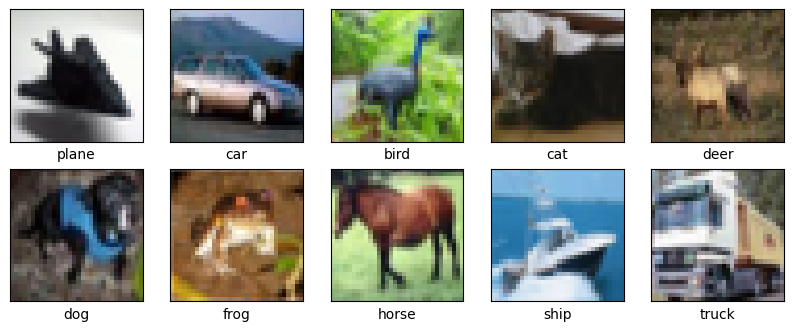

In [3]:
trainloader, testloader = load_cifar10()
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

# show 1 image per class

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainloader.dataset.data[trainloader.dataset.targets.index(i)])
    plt.xlabel(classes[i])
plt.show()

# Load a teacher model known to be good on ImageNet and create a small student model

In [4]:
class cifar_Teacher(torch.nn.Module):
    """
    A teacher model for CIFAR dataset.

    This model consists of convolutional layers followed by batch normalization and fully connected layers.
    The input to the model is expected to be a 3-channel image of size (batch_size, 3, height, width).

    Args:
        None

    Attributes:
        conv1 (torch.nn.Conv2d): Convolutional layer with 3 input channels and 64 output channels.
        pool (torch.nn.MaxPool2d): Max pooling layer with kernel size 2 and stride 2.
        norm1 (torch.nn.BatchNorm2d): Batch normalization layer with 64 channels.
        conv2 (torch.nn.Conv2d): Convolutional layer with 64 input channels and 128 output channels.
        norm2 (torch.nn.BatchNorm2d): Batch normalization layer with 128 channels.
        fc1 (torch.nn.Linear): Fully connected layer with 128 * 5 * 5 input features and 10 output features.

    Methods:
        forward(x): Performs forward pass through the model.

    Returns:
        torch.Tensor: Output tensor of shape (batch_size, 10) representing the class probabilities.
    """

    def __init__(self):
        super(cifar_Teacher, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.norm1 = torch.nn.BatchNorm2d(64)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.norm2 = torch.nn.BatchNorm2d(128)
        self.fc1 = torch.nn.Linear(128 * 5 * 5, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.norm1(x)
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.norm2(x)
        x = x.view(-1, 128 * 5 * 5)
        x = torch.nn.functional.softmax(self.fc1(x), dim=1)
        return x


class cifar_Student(torch.nn.Module):
    """
    A student model for CIFAR dataset.

    This model consists of convolutional layers followed by batch normalization and fully connected layers.
    The input to the model should be a 3-channel image of size (batch_size, 3, height, width).

    Args:
        None

    Returns:
        torch.Tensor: The output tensor of shape (batch_size, num_classes) representing the class probabilities.

    """

    def __init__(self):
        super(cifar_Student, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.norm1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.norm2 = torch.nn.BatchNorm2d(32)
        self.fc1 = torch.nn.Linear(32 * 5 * 5, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.norm1(x)
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.norm2(x)
        x = x.view(-1, 32 * 5 * 5)
        x = torch.nn.functional.softmax(self.fc1(x), dim=1)
        return x

In [5]:
def train_model(
    model: torch.nn.Module,
    dataloader: DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 10,
    device: str = "cpu",
) -> torch.nn.Module:
    """
    Trains a given model using the provided data and hyperparameters.

    Args:
        model (torch.nn.Module): The model to be trained.
        dataloader (DataLoader): The data loader containing the training and validation data.
        criterion (torch.nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model's parameters.
        num_epochs (int, optional): The number of training epochs. Defaults to 10.
        device (str, optional): The device to be used for training. Defaults to "cpu".

    Returns:
        torch.nn.Module: The trained model.

    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


def test_model(
    model: torch.nn.Module, dataloader: DataLoader, device: str = "cpu"
) -> Tuple[float, float]:
    """
    Test the given model on the provided dataloader.

    Args:
        model (torch.nn.Module): The model to be tested.
        dataloader (DataLoader): The dataloader containing the test data.
        device (str, optional): The device to run the model on. Defaults to "cpu".

    Returns:
        Tuple[float, float]: A tuple containing the accuracy and average time per sample.
    """
    start = time.time()
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    acc = running_corrects.double() / len(dataloader.dataset)
    end = time.time() - start
    return acc, end / len(dataloader.dataset)

In [6]:
teacher = cifar_Teacher()
student = cifar_Student()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
teacher.to(device)
student.to(device)

criterion = torch.nn.CrossEntropyLoss()

teacher_optimizer = torch.optim.SGD(teacher.parameters(), lr=0.001, momentum=0.9)
student_optimizer = torch.optim.SGD(student.parameters(), lr=0.001, momentum=0.9)

teacher_scheduler = torch.optim.lr_scheduler.StepLR(
    teacher_optimizer, step_size=7, gamma=0.1
)
student_scheduler = torch.optim.lr_scheduler.StepLR(
    student_optimizer, step_size=7, gamma=0.1
)

dataloaders = {"train": trainloader, "val": testloader}

In [7]:
# print models summary and number of parameters
def print_model_summary(model: torch.nn.Module, name: str):
    print("*" * 10, name, "*" * 10)
    print(model)
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    print("*" * (20 + len(name)))

In [8]:
print_model_summary(teacher, "Teacher")
print_model_summary(student, "Student")

********** Teacher **********
cifar_Teacher(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3200, out_features=10, bias=True)
)
242186
***************************
********** Student **********
cifar_Student(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, 

In [9]:
teacher = train_model(
    teacher, dataloaders, criterion, teacher_optimizer, num_epochs=5, device=device
)

Epoch 0/4
----------


train Loss: 1.9964 Acc: 0.4848
val Loss: 1.9130 Acc: 0.5627

Epoch 1/4
----------
train Loss: 1.8741 Acc: 0.6043
val Loss: 1.8529 Acc: 0.6239

Epoch 2/4
----------
train Loss: 1.8293 Acc: 0.6482
val Loss: 1.8290 Acc: 0.6442

Epoch 3/4
----------
train Loss: 1.8000 Acc: 0.6768
val Loss: 1.8119 Acc: 0.6622

Epoch 4/4
----------
train Loss: 1.7771 Acc: 0.7009
val Loss: 1.7996 Acc: 0.6738

Training complete in 13m 17s
Best val Acc: 0.6738


In [10]:
student = train_model(
    student, dataloaders, criterion, student_optimizer, num_epochs=5, device=device
)

Epoch 0/4
----------
train Loss: 2.0942 Acc: 0.3874
val Loss: 2.0024 Acc: 0.4799

Epoch 1/4
----------
train Loss: 1.9689 Acc: 0.5141
val Loss: 1.9530 Acc: 0.5284

Epoch 2/4
----------
train Loss: 1.9176 Acc: 0.5630
val Loss: 1.9032 Acc: 0.5749

Epoch 3/4
----------
train Loss: 1.8882 Acc: 0.5888
val Loss: 1.8769 Acc: 0.5956

Epoch 4/4
----------
train Loss: 1.8644 Acc: 0.6127
val Loss: 1.8660 Acc: 0.6092

Training complete in 7m 56s
Best val Acc: 0.6092


In [17]:
def distillation(
    student: torch.nn.Module,
    teacher: torch.nn.Module,
    dataloader: DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 10,
    device: str = "cpu",
    teacher_only: bool = True,
) -> torch.nn.Module:
    """
    Perform knowledge distillation between a student and a teacher model.

    Args:
        student (torch.nn.Module): The student model to be trained.
        teacher (torch.nn.Module): The teacher model used for knowledge distillation.
        dataloader (DataLoader): The data loader containing the training and validation data.
        criterion (torch.nn.Module): The loss function used for training the student model.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the student model's parameters.
        num_epochs (int, optional): The number of epochs to train the student model. Defaults to 10.
        device (str, optional): The device to run the training on (e.g., "cpu", "cuda"). Defaults to "cpu".
        teacher_only (bool, optional): Whether to use only the teacher's outputs for distillation loss.
            If False, both the student's outputs and the teacher's outputs will be used. Defaults to True.

    Returns:
        torch.nn.Module: The trained student model.

    """
    since = time.time()
    best_model_wts = copy.deepcopy(student.state_dict())
    best_acc = 0.0
    teacher.eval()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)
        for phase in ["train", "val"]:
            if phase == "train":
                student.train()
            else:
                student.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs_student = student(inputs)
                    with torch.no_grad():
                        outputs_teacher = teacher(inputs)
                    if teacher_only:
                        loss = criterion(outputs_student, outputs_teacher)
                    else:
                        loss = criterion(outputs_student, labels) + criterion(
                            outputs_student, outputs_teacher
                        )
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(
                    torch.max(outputs_student, 1).indices == labels.data
                )
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(student.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")
    student.load_state_dict(best_model_wts)
    return student

In [16]:
student_rb = cifar_Student()
student_rb.to(device)
student_rb_optimizer = torch.optim.SGD(student_rb.parameters(), lr=0.001, momentum=0.9)

student_rb = distillation(
    student_rb,
    teacher,
    dataloaders,
    criterion,
    student_rb_optimizer,
    num_epochs=5,
    device=device,
)

Epoch 0/4
----------


train Loss: 2.0192 Acc: 0.4032
val Loss: 1.9026 Acc: 0.4830

Epoch 1/4
----------
train Loss: 1.8666 Acc: 0.5235
val Loss: 1.8242 Acc: 0.5553

Epoch 2/4
----------
train Loss: 1.8027 Acc: 0.5680
val Loss: 1.7728 Acc: 0.5850

Epoch 3/4
----------
train Loss: 1.7706 Acc: 0.5942
val Loss: 1.7492 Acc: 0.5983

Epoch 4/4
----------
train Loss: 1.7495 Acc: 0.6060
val Loss: 1.7361 Acc: 0.6068

Training complete in 11m 56s
Best val Acc: 0.6068


In [18]:
student_rb_noto = cifar_Student()
student_rb_noto.to(device)

student_rb_noto_optimizer = torch.optim.SGD(
    student_rb_noto.parameters(), lr=0.001, momentum=0.9
)

student_rb_noto = distillation(
    student_rb_noto,
    teacher,
    dataloaders,
    criterion,
    student_rb_noto_optimizer,
    num_epochs=5,
    device=device,
    teacher_only=False,
)

Epoch 0/4
----------
train Loss: 3.9989 Acc: 0.4515
val Loss: 3.7783 Acc: 0.5388

Epoch 1/4
----------
train Loss: 3.7147 Acc: 0.5746
val Loss: 3.7007 Acc: 0.5655

Epoch 2/4
----------
train Loss: 3.6289 Acc: 0.6087
val Loss: 3.6081 Acc: 0.6100

Epoch 3/4
----------
train Loss: 3.5801 Acc: 0.6306
val Loss: 3.5632 Acc: 0.6278

Epoch 4/4
----------
train Loss: 3.5471 Acc: 0.6471
val Loss: 3.5440 Acc: 0.6381

Training complete in 12m 37s
Best val Acc: 0.6381


In [19]:
# get the accuracy and inference time of the models

teacher_acc, teacher_time = test_model(teacher, testloader, device)

student_acc, student_time = test_model(student, testloader, device)

student_rb_acc, student_rb_time = test_model(student_rb, testloader, device)

student_rb_noto_acc, student_rb_noto_time = test_model(
    student_rb_noto, testloader, device
)

In [21]:
results = pd.DataFrame(
    {
        "Model": ["Teacher", "Student", "Student+KD", "Student+KD+noTO"],
        "Accuracy": [teacher_acc, student_acc, student_rb_acc, student_rb_noto_acc],
        "Inference Time": [
            teacher_time,
            student_time,
            student_rb_time,
            student_rb_noto_time,
        ],
    }
)

print(results)

             Model                             Accuracy  Inference Time
0          Teacher  tensor(0.6738, dtype=torch.float64)        0.004642
1          Student  tensor(0.6092, dtype=torch.float64)        0.003996
2       Student+KD  tensor(0.6068, dtype=torch.float64)        0.003999
3  Student+KD+noTO  tensor(0.6381, dtype=torch.float64)        0.004024


## Résultats intéressants, quand le student est entrainé tout seul / seulement avec le teacher les résultats sont similaires mais quand on combine les loss du teacher / original les résultats sont plus satisfaisants.

## On pourrait penser que cela vient du fait que le teacher n'aient pas pu tout apprendre du dataset (68% acc) 